In [3]:
import json
import pickle
import logging
import os
import warnings

import joblib
import mlflow
import numpy as np
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, 
                             ConfusionMatrixDisplay, precision_recall_fscore_support, 
                             precision_score, recall_score, roc_auc_score)
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
warnings.filterwarnings("ignore")

### Model building baseline with mlflow tracking 

In [4]:
def read_csv(file_name: str, path="data/data_processed") -> pd.DataFrame:
    """
    Read csv file
    :param file_name: file name
    :param path: path to the file
    :return: pandas dataframe
    """
    return pd.read_csv(os.path.join(path, file_name))

In [5]:
df_tickets = read_csv("tickets_inputs_eng_1.csv")

In [6]:
df_tickets.shape

(18957, 4)

In [7]:
df_tickets.sample(5)

,complaint_what_happened,ticket_classification,processed_text,relevant_topics
15110,"Since XX/XX/2019, I have been in constant cont...",Vehicle loan or lease + Loan,sinc 2019 contact company loan com month hav ...,Mortgage/Loan
11142,I made a reservation at a hotel in XXXX on XX/...,Credit card or prepaid card + General-purpose ...,i reservation hotel reservation penalty arri...,Mortgage/Loan
8228,I made a payment on XX/XX/2020 to my Chase Fre...,"Credit reporting, credit repair services, or o...",i payment 2020 chas freedom credit card amount...,Mortgage/Loan
3501,"RE : Chase Bank ATM, To whom it may concern, I...","Money transfer, virtual currency, or money ser...",re bank atm concern i complaint consum protect...,Mortgage/Loan
2438,I filed a dispute with XXXX Credit Bureau rega...,"Credit reporting, credit repair services, or o...",i disput credit bureau inquir credit report ha...,Mortgage/Loan


In [8]:
df_tickets.relevant_topics.value_counts() #positivo para desbalance but, la vida es así y hay que seguir adelante

relevant_topics
Mortgage/Loan                    16648
Bank Account Services             2132
Credit Report or Prepaid Card      177
Name: count, dtype: int64

In [9]:
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("tickets_baseline")


def data_transform(df: pd.DataFrame):
    """This function transform the data into X and y
    Args:
      df (pd.DataFrame): dataframe with the data
    Returns:
      X (pd.Series): series with the text
      y (pd.Series): series with the labels"""
    X = df["processed_text"]
    y = df["relevant_topics"]

    return X, y


def read_idx2label(json_path: str) -> pd.Series:
    """This function read the json file and return a dictionary
    Args:
      json_path (str): path to the json file
     Returns:
      idx2label (dict): dictionary with the mapping"""
    with open(json_path) as f:
        idx2label = json.load(f)
    return idx2label


def decode_labels_into_idx(labels: pd.Series, idx2label: dict) -> pd.Series:
    """This function decode the labels into idx
    Args:
      labels (pd.Series): series with the labels
      idx2label (dict): dictionary with the mapping
     Returns:
      labels (pd.Series): series with the labels decoded
    """
    return labels.map(idx2label)


def fit_transform(X: pd.Series) -> np.ndarray:
    count_vectorizer = CountVectorizer()
    X_vectorized = count_vectorizer.fit_transform(X)
    #save count vectorizer for data preprocessing in the main app (deploy)
    joblib.dump(count_vectorizer, 'data/data_processed/count_vectorizer.pkl')
    logger.info("count vectorizer trained successfully stored")
    return X_vectorized


def transform_tfidf(X_vectorized: object) -> np.ndarray:
    tfidf_transformer = TfidfTransformer()
    X_tfidf = tfidf_transformer.fit_transform(X_vectorized)
    joblib.dump(X_tfidf, 'data/data_processed/X_tfidf.pkl')
    logger.info("X_tfidf trained successfully stored")
    return X_tfidf

def save_pickle(data, filename) -> None:
    """
    This function saves the data in a pickle file
    Args:
        data (object): data to save
        filename (str): filename
    Returns:
        None
    """
    filepath = os.path.join("data", "data_processed", f"{filename}.pkl")
    with open(filepath, 'wb') as file:
        pickle.dump(data, file)

def split_train_test(
    X_tfidf: np.array, y: pd.Series, test_size: float = 0.3, random_state: int = 42
) -> tuple:
    """
    This function splits the data into train and test
    Args:
      X_tfidf (np.array): array with the vectorized data
      y (pd.Series): series with the labels
      test_size (float): test size
      random_state (int): random state
    Returns:
      X_train (np.array): array with the vectorized data for train
      X_test (np.array): array with the vectorized data for test
      y_train (pd.Series): series with the labels for train
      y_test (pd.Series): series with the labels for test
    """
    X_train, X_test, y_train, y_test = train_test_split(
        X_tfidf, y, test_size=test_size, random_state=random_state
    )
    save_pickle((X_train, y_train), "train")
    save_pickle((X_test, y_test),  "test")
    logger.info("data saved successfully in pickle files")
    return X_train, X_test, y_train, y_test

def display_classification_report(
    model: object,
    name_model: str,
    developer: str,
    X_train: np.array,
    X_test: np.array,
    y_train: np.array,
    y_test: np.array,
    use_cv = False
):
    """This function display the classification report
    Args:
      model (object): model
      name_model (str): name of the model
      developer (str): developer name
      X_train (np.array): array with the vectorized data for train
      X_test (np.array): array with the vectorized data for test
      y_train (pd.Series): series with the labels for train
      y_test (pd.Series): series with the labels for test
     Returns:
      metric (list): list with the metrics"""
    
    # star experiment in mlflow
    with mlflow.start_run(run_name=name_model):
        mlflow.log_param("model", name_model)
        mlflow.log_param("developer", developer)
        # empty list to store the metrics and then tracking them in mlflow
        metric = []
        y_train_pred_proba = model.predict_proba(X_train)
        y_test_pred_proba = model.predict_proba(X_test)
        roc_auc_score_train = round(
            roc_auc_score(
                y_train, y_train_pred_proba, average="weighted", multi_class="ovr"
            ),
            2,
        )
        roc_auc_score_test = round(
            roc_auc_score(
                y_test, y_test_pred_proba, average="weighted", multi_class="ovr"
            ),
            2,
        )

        logger.info("ROC AUC Score Train:", roc_auc_score_train)
        logger.info("ROC AUC Score Test:", roc_auc_score_test)
        
        # adding the metrics to the list
        metric.extend([roc_auc_score_train, roc_auc_score_test])

        mlflow.log_metric("roc_auc_train", roc_auc_score_train)
        mlflow.log_metric("roc_auc_test", roc_auc_score_test)

        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        (
            precision_train,
            recall_train,
            fscore_train,
            support_train,
        ) = precision_recall_fscore_support(y_train, y_train_pred, average="weighted")
        (
            precision_test,
            recall_test,
            fscore_test,
            support_test,
        ) = precision_recall_fscore_support(y_test, y_test_pred, average="weighted")

        mlflow.log_metric("precision_train", precision_train)
        mlflow.log_metric("precision_test", precision_test)
        mlflow.log_metric("recall_train", recall_train)
        mlflow.log_metric("recall_test", recall_test)
        
        try:
            if use_cv:
                best_params = model.best_params_
            else:
                best_params = model.get_params()
            mlflow.log_params(best_params)

        except AttributeError as e:
            logger.info(f"Error: {e}")

        mlflow.sklearn.log_model(model, f"model_{name_model}")

        acc_score_train = round(accuracy_score(y_train, y_train_pred), 2)
        acc_score_test = round(accuracy_score(y_test, y_test_pred), 2)

        metric.extend(
            [
                acc_score_train,
                acc_score_test,
                round(precision_train, 2),
                round(precision_test, 2),
                round(recall_train, 2),
                round(recall_test, 2),
                round(fscore_train, 2),
                round(fscore_test, 2),
            ]
        )

        print("Train Accuracy: ", acc_score_train)
        print("Test Accuracy: ", acc_score_test)

        model_report_train = classification_report(y_train, y_train_pred)
        model_report_test = classification_report(y_test, y_test_pred)

        print("Classification Report for Train:\n", model_report_train)
        print("Classification Report for Test:\n", model_report_test)

        # Plot the confusion matrix
        fig, ax = plt.subplots(figsize=(12, 8))

        # Create the confusion matrix with labels decoded
        decoded_y_test_pred = [idx2label[idx] for idx in y_test_pred]
        decoded_y_test = [idx2label[idx] for idx in y_test]

        cm = confusion_matrix(decoded_y_test, decoded_y_test_pred)
        cmp = ConfusionMatrixDisplay(cm, display_labels=list(idx2label.values()))
        cmp.plot(ax=ax)

        plt.xticks(rotation=80)
        plt.show()

        mlflow.sklearn.log_model(model, f"models/{name_model}")

        return metric


def grid_search(model, folds, params, scoring):
    """This function perform a grid search
    Args:
        model (object): model
        folds (int): number of folds
        params (dict): dictionary with the parameters
        scoring (str): scoring
    Returns:
        grid_search (object): grid search
    """

    grid_search = GridSearchCV(
        model, cv=folds, param_grid=params, scoring=scoring, n_jobs=-1, verbose=1
    )
    return grid_search


def print_best_score_params(model):
    """This functions print best score and best hyperparameters for baselines models
    Args:
        model (object): model
    Returns:
        None"""
    print("Best Score: ", model.best_score_)
    print("Best Hyperparameters: ", model.best_params_)

2025/12/19 15:20:51 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/12/19 15:20:51 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Running upgrade  -> 451aebb31d03, add metric step
INFO  [alembic.runtime.migration] Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
INFO  [alembic.runtime.migration] Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
INFO  [alembic.runtime.migration] Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
INFO  [alembic.runtime.migration] Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
INFO  [alembic.runtime.migration] Running upgrade 7ac759974ad8 -> 89d4b8295536, create latest metrics table
INFO  [89d4b8295536_create_latest_metrics_table_py] Migration complete!
INFO  

In [10]:


idx2label = read_idx2label(json_path="data/data_processed/topic_mapping_1.json")
label2idx = {value: key for key, value in idx2label.items()}

X, y = data_transform(df_tickets)
y = decode_labels_into_idx(labels=y, idx2label=label2idx)

X_vectorized = fit_transform(X.values)
X_tfidf = transform_tfidf(X_vectorized)
X_train, X_test, y_train, y_test = split_train_test(X_tfidf, y)

<h2 style="color: pink;">Modelo Multinomial Naive Bayes</h2>


2025/12/19 15:54:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Train Accuracy:  0.88
Test Accuracy:  0.88
Classification Report for Train:
               precision    recall  f1-score   support

           0       0.33      0.00      0.00      1490
           1       0.00      0.00      0.00       119
           2       0.88      1.00      0.94     11660

    accuracy                           0.88     13269
   macro avg       0.40      0.33      0.31     13269
weighted avg       0.81      0.88      0.82     13269

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       642
           1       0.00      0.00      0.00        58
           2       0.88      1.00      0.93      4988

    accuracy                           0.88      5688
   macro avg       0.29      0.33      0.31      5688
weighted avg       0.77      0.88      0.82      5688



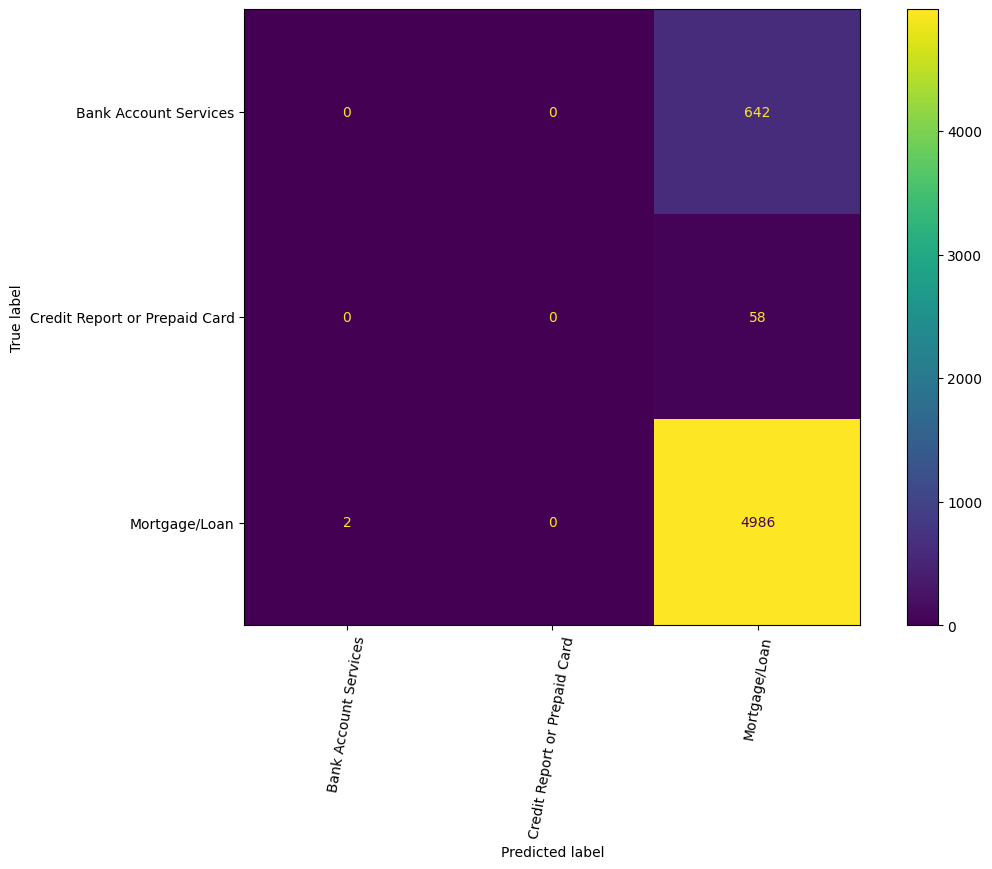

2025/12/19 15:54:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


[0.62, 0.53, 0.88, 0.88, 0.81, 0.77, 0.88, 0.88, 0.82, 0.82]

In [11]:
mnb = MultinomialNB()
mnb.fit(X_train, y_train)
display_classification_report(model=mnb, 
                              name_model="MultinomialNB", 
                              developer="Maria", 
                              X_train=X_train, 
                              X_test=X_test, 
                              y_train=y_train, 
                              y_test=y_test)

<h2 style="color: pink;">Modelo Multinomial Naive Bayes con GreadSearch</h2>

Fitting 5 folds for each of 5 candidates, totalling 25 fits


Best Score:  0.8785891957775688
Best Hyperparameters:  {'alpha': 1}


2025/12/19 15:58:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Train Accuracy:  0.88
Test Accuracy:  0.88
Classification Report for Train:
               precision    recall  f1-score   support

           0       0.33      0.00      0.00      1490
           1       0.00      0.00      0.00       119
           2       0.88      1.00      0.94     11660

    accuracy                           0.88     13269
   macro avg       0.40      0.33      0.31     13269
weighted avg       0.81      0.88      0.82     13269

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       642
           1       0.00      0.00      0.00        58
           2       0.88      1.00      0.93      4988

    accuracy                           0.88      5688
   macro avg       0.29      0.33      0.31      5688
weighted avg       0.77      0.88      0.82      5688



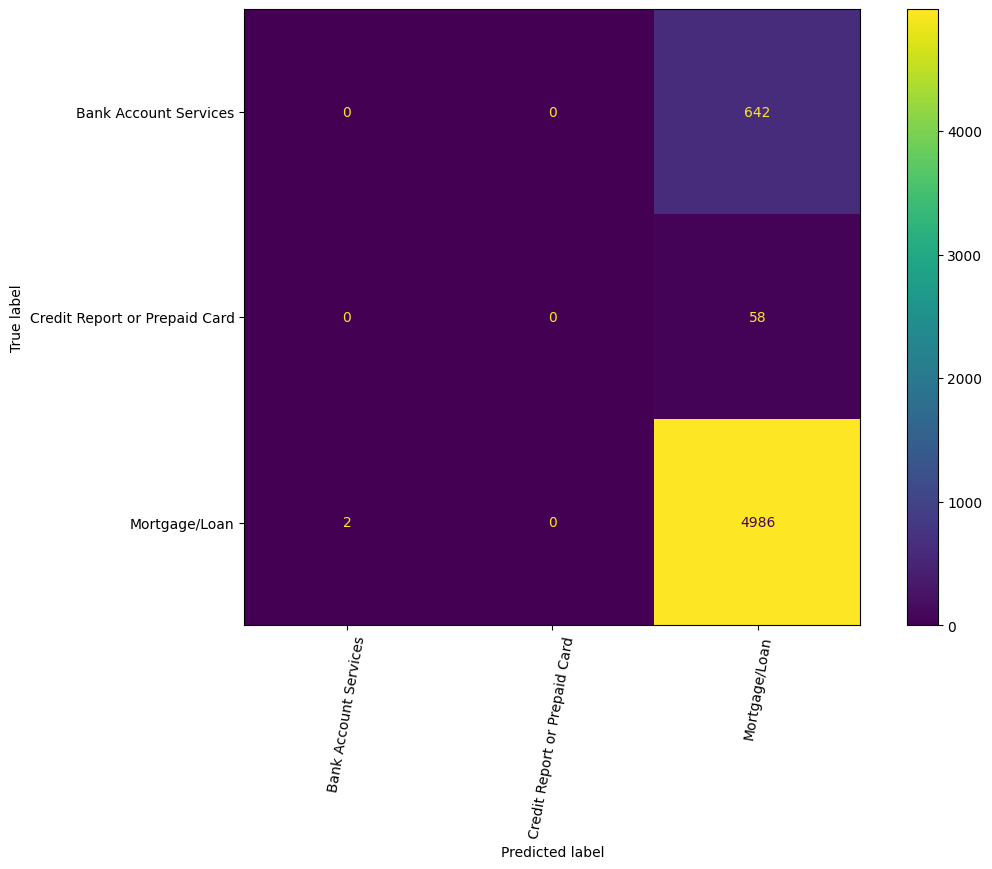

2025/12/19 15:58:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


[0.62, 0.53, 0.88, 0.88, 0.81, 0.77, 0.88, 0.88, 0.82, 0.82]

In [13]:
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 40)
mnb = MultinomialNB()
mnb_params = {  
'alpha': (1, 0.1, 0.01, 0.001, 0.0001)  
}
grid_search_mnb = grid_search(mnb, folds, mnb_params, scoring="f1_micro")
grid_search_mnb.fit(X_train, y_train)
print_best_score_params(grid_search_mnb)

display_classification_report(model=grid_search_mnb, 
                              name_model="MultinomialNBCV", 
                              developer="Maria", 
                              X_train=X_train, 
                              X_test=X_test, 
                              y_train=y_train, 
                              y_test=y_test, 
                              use_cv= True)

<h2 style="color: pink;">Logistic Regression</h2>

2025/12/19 15:58:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Train Accuracy:  0.88
Test Accuracy:  0.88
Classification Report for Train:
               precision    recall  f1-score   support

           0       0.81      0.01      0.02      1490
           1       0.00      0.00      0.00       119
           2       0.88      1.00      0.94     11660

    accuracy                           0.88     13269
   macro avg       0.56      0.34      0.32     13269
weighted avg       0.86      0.88      0.82     13269

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.17      0.00      0.01       642
           1       0.00      0.00      0.00        58
           2       0.88      1.00      0.93      4988

    accuracy                           0.88      5688
   macro avg       0.35      0.33      0.31      5688
weighted avg       0.79      0.88      0.82      5688



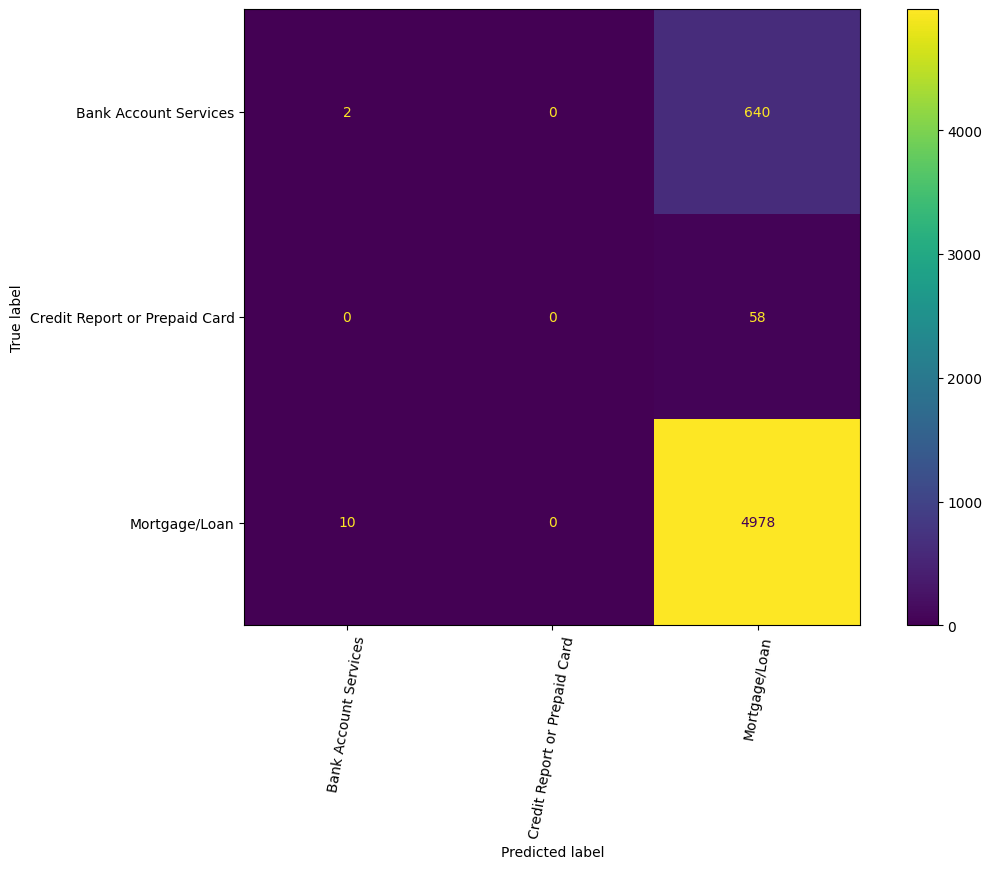

2025/12/19 15:58:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


[0.82, 0.62, 0.88, 0.88, 0.86, 0.79, 0.88, 0.88, 0.82, 0.82]

In [14]:
log_reg = LogisticRegression(random_state=40,solver='liblinear')
log_reg.fit(X_train,y_train)
display_classification_report(model=log_reg, 
                              name_model="LogisticRegression", 
                              developer="Maria", 
                              X_train=X_train, 
                              X_test=X_test, 
                              y_train=y_train, 
                              y_test=y_test, 
                              use_cv=False)

<h2 style="color: pink;">Logistic Regression with GreadSearch</h2>

Fitting 5 folds for each of 18 candidates, totalling 90 fits


/home/codespace/.cache/pypoetry/virtualenvs/mlops-curso-PhZUhOu0-py3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/codespace/.cache/pypoetry/virtualenvs/mlops-curso-PhZUhOu0-py3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/codespace/.cache/pypoetry/virtualenvs/mlops-curso-PhZUhOu0-py3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/codespace/.cache/pypoetry/virtualenvs/mlops-curso-PhZUhOu0-py3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/codespace/.cache/pypoetry/virtualenvs/mlops-curso-

Best Score:  0.920154373927959
Best Hyperparameters:  {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}


2025/12/19 16:03:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Train Accuracy:  0.97
Test Accuracy:  0.75
Classification Report for Train:
               precision    recall  f1-score   support

           0       0.94      0.97      0.96     11660
           1       1.00      1.00      1.00     11660
           2       0.97      0.94      0.96     11660

    accuracy                           0.97     34980
   macro avg       0.97      0.97      0.97     34980
weighted avg       0.97      0.97      0.97     34980

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.14      0.22      0.17       642
           1       0.04      0.03      0.04        58
           2       0.88      0.83      0.85      4988

    accuracy                           0.75      5688
   macro avg       0.36      0.36      0.35      5688
weighted avg       0.79      0.75      0.77      5688



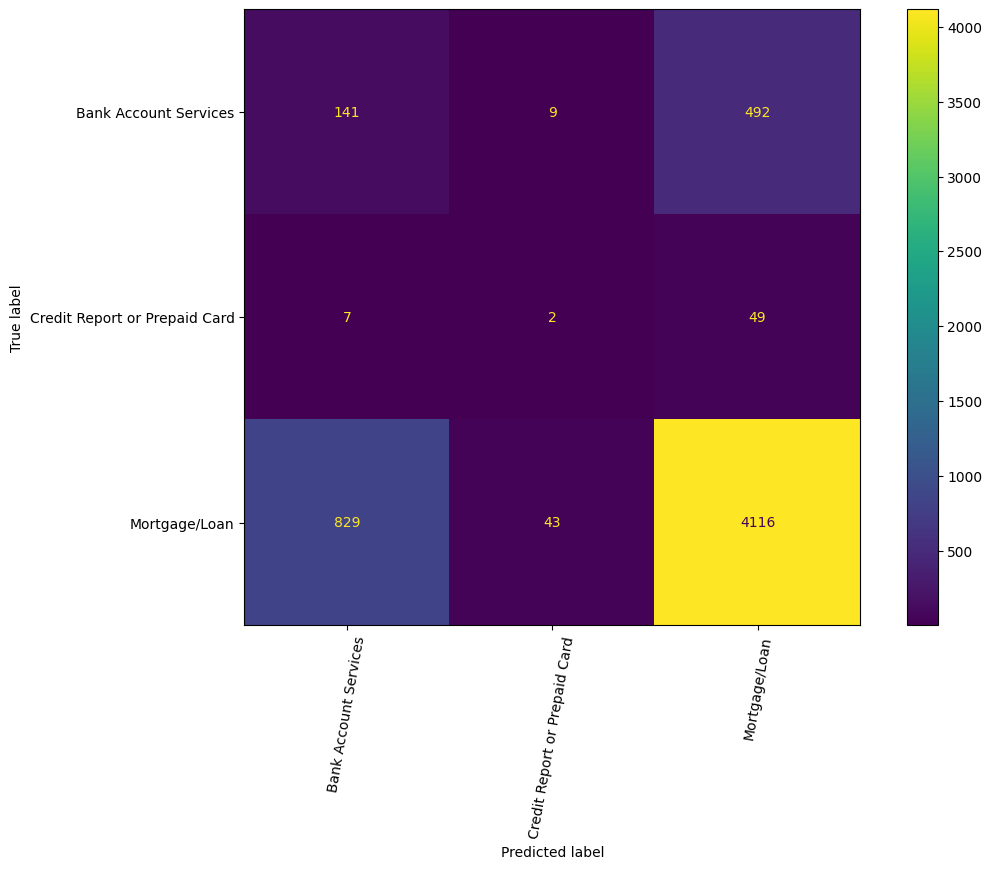

2025/12/19 16:03:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


[1.0, 0.54, 0.97, 0.75, 0.97, 0.79, 0.97, 0.75, 0.97, 0.77]

In [15]:
# rebalance of the data
smote = SMOTE()
# transform the dataset with the SMOTE algorithm
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
# define the model with the balanced class_weight
log_reg = LogisticRegression(class_weight='balanced')

log_params = {'C': [0.01, 1, 10], 
          'penalty': ['l1', 'l2'],
          'solver': ['liblinear','newton-cg','saga']
         }

grid_search_log = grid_search(log_reg, folds, log_params, scoring="f1_micro")
grid_search_log.fit(X_train_res, y_train_res)  # entrenamiento con los datos rebalanceados

print_best_score_params(grid_search_log)
display_classification_report(grid_search_log,
                              name_model="LogisticRegressionCVSmote", 
                              developer="Maria", 
                              X_train=X_train_res,  # evaluación con los datos rebalanceados
                              X_test=X_test, 
                              y_train=y_train_res,  # etiquetas rebalanceadas
                              y_test=y_test, 
                              use_cv=True)

<h2 style="color: pink;">Decision Tree Classifier</h2>

2025/12/19 16:03:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Train Accuracy:  1.0
Test Accuracy:  0.81
Classification Report for Train:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1490
           1       1.00      1.00      1.00       119
           2       1.00      1.00      1.00     11660

    accuracy                           1.00     13269
   macro avg       1.00      1.00      1.00     13269
weighted avg       1.00      1.00      1.00     13269

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.18      0.15      0.16       642
           1       0.03      0.02      0.02        58
           2       0.88      0.91      0.90      4988

    accuracy                           0.81      5688
   macro avg       0.36      0.36      0.36      5688
weighted avg       0.80      0.81      0.80      5688



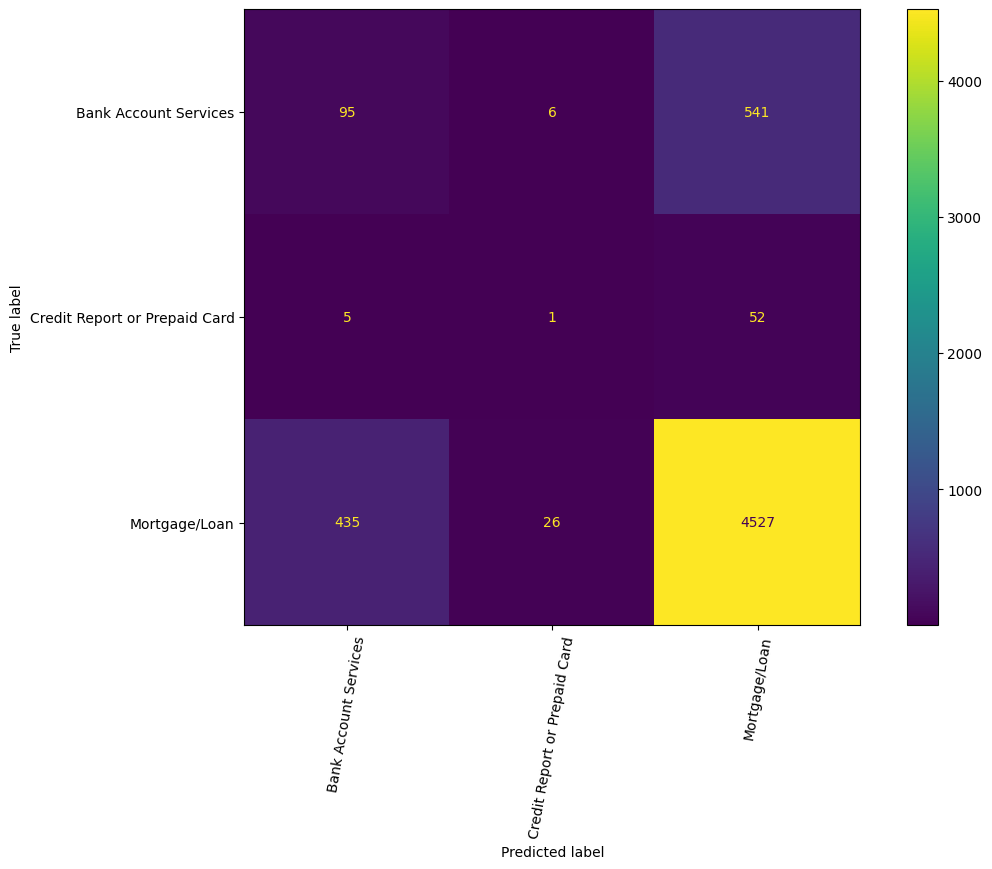

2025/12/19 16:03:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


[1.0, 0.53, 1.0, 0.81, 1.0, 0.8, 1.0, 0.81, 1.0, 0.8]

In [16]:
dtc = DecisionTreeClassifier(random_state=40)
dtc.fit(X_train,y_train)
display_classification_report(model=dtc,
                              name_model="DecisionTreeClassifier",
                              developer="Maria",
                              X_train=X_train,
                              X_test=X_test,
                              y_train=y_train,
                              y_test=y_test,
                              use_cv=False)

<h2 style="color: pink;">Decision Tree Classifier with Gread Search</h2>

Fitting 5 folds for each of 512 candidates, totalling 2560 fits


Best Score:  0.3645190847004367
Best Hyperparameters:  {'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 2, 'splitter': 'random'}


2025/12/19 16:11:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Train Accuracy:  0.96
Test Accuracy:  0.79
Classification Report for Train:
               precision    recall  f1-score   support

           0       0.79      0.98      0.87      1490
           1       0.67      0.69      0.68       119
           2       1.00      0.97      0.98     11660

    accuracy                           0.96     13269
   macro avg       0.82      0.88      0.84     13269
weighted avg       0.97      0.96      0.97     13269

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.15      0.16      0.16       642
           1       0.00      0.00      0.00        58
           2       0.88      0.88      0.88      4988

    accuracy                           0.79      5688
   macro avg       0.35      0.35      0.35      5688
weighted avg       0.79      0.79      0.79      5688



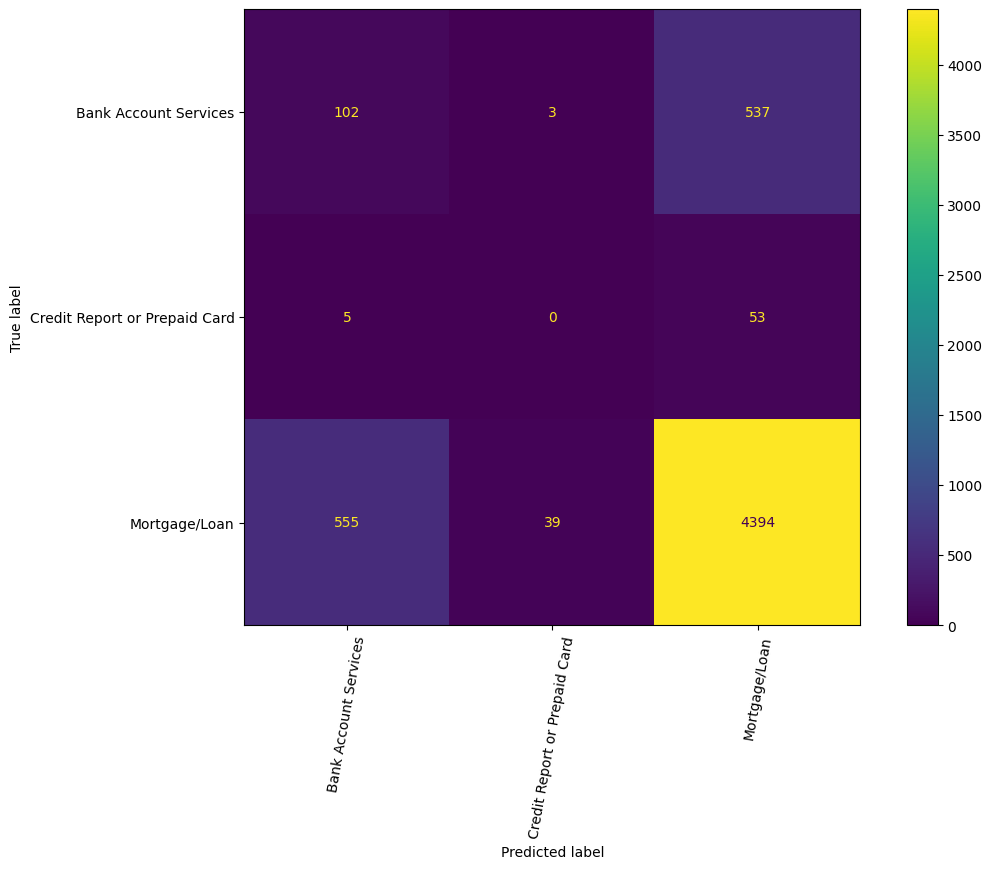

2025/12/19 16:11:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


[0.99, 0.52, 0.96, 0.79, 0.97, 0.79, 0.96, 0.79, 0.97, 0.79]

In [17]:
# decis|on tree classifier with grid search
dtc_cv = DecisionTreeClassifier(random_state=40)

dtc_params = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [2,3,4,5,6,7,8,None],
    'min_samples_leaf': [2,3,4,7],
    'max_features': ['auto', 'sqrt', 'log2', None]
}
grid_search_dtc = grid_search(dtc_cv, folds, dtc_params, scoring='f1_macro')
grid_search_dtc.fit(X_train, y_train)
print_best_score_params(grid_search_dtc)
display_classification_report(grid_search_dtc, 
                              name_model="DecisionTreeClassifierCV", 
                              developer="Maria", 
                              X_train=X_train, 
                              X_test=X_test, 
                              y_train=y_train, 
                              y_test=y_test, 
                              use_cv=True)

* No olvides ejecutar mlflow ui --backend-store-uri sqlite:///mlflow.db para visualizar los resultados

<h2 style="color: pink;">Hacer inferencias con el modelo</h2>

In [20]:
logged_model = 'runs:/e62f3886d5624a38ba8790d814084af5/models/DecisionTreeClassifier'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

In [21]:
assert X_train.toarray().shape[0] == y_train.shape[0]

In [22]:
loaded_model

mlflow.pyfunc.loaded_model:
  artifact_path: models/DecisionTreeClassifier
  flavor: mlflow.sklearn
  run_id: e62f3886d5624a38ba8790d814084af5

In [23]:
lr_model = mlflow.sklearn.load_model(logged_model)

In [24]:
lr_model.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': 40,
 'splitter': 'best'}

In [25]:
lr_model.predict(X_test)

array(['2', '2', '0', ..., '2', '2', '2'], dtype=object)

In [26]:
from mlflow.tracking import MlflowClient
MLFLOW_TRACKING_URI = "sqlite:///mlflow.db"
client = MlflowClient(tracking_uri=MLFLOW_TRACKING_URI)

In [27]:
runs = mlflow.search_runs()
# Extrae los IDs únicos de los experimentos
experiment_ids = runs['experiment_id'].unique()

In [28]:
experiment_ids

array(['1'], dtype=object)

In [29]:
client.create_experiment("regression_models")

'2'

In [30]:
runs = client.search_runs(experiment_ids=["1"])
for run in runs:
    print(run.info)

<RunInfo: artifact_uri='/workspaces/Mlops-platzi/tracking/mlruns/1/118687801801410385a5680fea17948f/artifacts', end_time=1766160668293, experiment_id='1', lifecycle_stage='active', run_id='118687801801410385a5680fea17948f', run_name='DecisionTreeClassifierCV', run_uuid='118687801801410385a5680fea17948f', start_time=1766160658998, status='FINISHED', user_id='codespace'>
<RunInfo: artifact_uri='/workspaces/Mlops-platzi/tracking/mlruns/1/e62f3886d5624a38ba8790d814084af5/artifacts', end_time=1766160239615, experiment_id='1', lifecycle_stage='active', run_id='e62f3886d5624a38ba8790d814084af5', run_name='DecisionTreeClassifier', run_uuid='e62f3886d5624a38ba8790d814084af5', start_time=1766160232991, status='FINISHED', user_id='codespace'>
<RunInfo: artifact_uri='/workspaces/Mlops-platzi/tracking/mlruns/1/7d0e7e5e211643e9aa33eb1921a6ad65/artifacts', end_time=1766160211976, experiment_id='1', lifecycle_stage='active', run_id='7d0e7e5e211643e9aa33eb1921a6ad65', run_name='LogisticRegressionCVSmot

💚 Ahora vayamos a la UI y miremos los resultados de los modelos y hagamos un registro de un par de modelos con mejor performancce. 

<p align="center">
  <img src="https://pbs.twimg.com/media/EoOBoWyWEAAA8In.jpg" width="400" style="display: block; margin: auto;">
</p>

### Promote a model

In [31]:
runs= client.search_runs(
    experiment_ids='1',
    filter_string="", #se puede usar un tag en especial o algún parámetro de interés ej: 'tags.model = valor que usaste
    run_view_type=mlflow.entities.ViewType.ACTIVE_ONLY,
    max_results=5,
    order_by=["metrics.precision_test DESC"]

)

In [32]:
for run in runs:
    print(f"run id: {run.info.run_id}, rmse_valid: {run.data.metrics['precision_test']}")

run id: e62f3886d5624a38ba8790d814084af5, rmse_valid: 0.7957183292910647
run id: 7d0e7e5e211643e9aa33eb1921a6ad65, rmse_valid: 0.7917280520156711
run id: 118687801801410385a5680fea17948f, rmse_valid: 0.7905142253435699
run id: 29272a68911445aeb699f733edf5c666, rmse_valid: 0.7879054255636535
run id: 1c40b1c9214545b291f425950aed8f56, rmse_valid: 0.7689750976192914


In [35]:
run_id = "e62f3886d5624a38ba8790d814084af5"
model_uri = f"runs:/{run_id}/model"
mlflow.register_model(model_uri, "tickets_classifiers")

Registered model 'tickets_classifiers' already exists. Creating a new version of this model...
Created version '3' of model 'tickets_classifiers'.


<ModelVersion: aliases=[], creation_timestamp=1766163054938, current_stage='None', description=None, last_updated_timestamp=1766163054938, name='tickets_classifiers', run_id='e62f3886d5624a38ba8790d814084af5', run_link=None, source='/workspaces/Mlops-platzi/tracking/mlruns/1/e62f3886d5624a38ba8790d814084af5/artifacts/model', status='READY', status_message=None, tags={}, user_id=None, version=3>

In [36]:
model_name = "tickets_classifiers"
latest_versions = client.get_latest_versions(name=model_name)
for version in latest_versions:
    print(f" version: {version.version} , actual stage: {version._current_stage}")

 version: 2 , actual stage: Staging
 version: 3 , actual stage: None


In [37]:
client.transition_model_version_stage(
    name=model_name,
    version=3,
    stage="Staging"
)

<ModelVersion: aliases=[], creation_timestamp=1766163054938, current_stage='Staging', description=None, last_updated_timestamp=1766163295899, name='tickets_classifiers', run_id='e62f3886d5624a38ba8790d814084af5', run_link=None, source='/workspaces/Mlops-platzi/tracking/mlruns/1/e62f3886d5624a38ba8790d814084af5/artifacts/model', status='READY', status_message=None, tags={}, user_id=None, version=3>

In [38]:
client.transition_model_version_stage(
    name=model_name,
    version=1,
    stage="Production"
)

<ModelVersion: aliases=[], creation_timestamp=1766161815418, current_stage='Production', description='', last_updated_timestamp=1766163391033, name='tickets_classifiers', run_id='e62f3886d5624a38ba8790d814084af5', run_link='', source='/workspaces/Mlops-platzi/tracking/mlruns/1/e62f3886d5624a38ba8790d814084af5/artifacts/models/DecisionTreeClassifier', status='READY', status_message=None, tags={'model': 'dt_class'}, user_id=None, version=1>

In [39]:
client.update_model_version(
    name=model_name, 
    version=2,
    description=f"The model version {2} was transitioned to Production on {datetime.today().date()}"
)

<ModelVersion: aliases=[], creation_timestamp=1766162173530, current_stage='Staging', description='The model version 2 was transitioned to Production on 2025-12-19', last_updated_timestamp=1766163452219, name='tickets_classifiers', run_id='7d0e7e5e211643e9aa33eb1921a6ad65', run_link='', source='/workspaces/Mlops-platzi/tracking/mlruns/1/7d0e7e5e211643e9aa33eb1921a6ad65/artifacts/models/LogisticRegressionCVSmote', status='READY', status_message=None, tags={}, user_id=None, version=2>

In [40]:
type(y_test)

pandas.core.series.Series

## Sometamos a prueba el modelo que hemos registrado para producción

In [41]:
import scipy

In [42]:
def testint_model_from_mlflow(model_name: str, stage:str, X_test: scipy.sparse._csr.csr_matrix, Y_test: pd.Series):
    """this function tests a model from mlflow
    Args:
        model_name (str): name of the model
        stage (str): stage of the model
        X_test (scipy.sparse._csr.csr_matrix): test data
        Y_test (scipy.sparse._csr.csr_matrix): test target
    Returns:
        float: rmse of the model
    
    """
    model_uri = f"models:/{model_name}/{stage}"
    model = mlflow.pyfunc.load_model(model_uri)
    y_pred = model.predict(X_test)
    acc_score = round(accuracy_score(Y_test, y_pred), 2)
    return {"rmse": acc_score}

In [43]:
%time
testint_model_from_mlflow(model_name= "tickets_classifiers", stage="Production", X_test=X_test, Y_test=y_test)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.63 µs


{'rmse': 0.81}

## Ventajas de MLflow:

* Gestión de Ciclo de Vida: Facilita el seguimiento de experimentos, versionado de modelos y reproducción de resultados.
* Interoperabilidad: Es compatible con múltiples frameworks de aprendizaje automático y se integra fácilmente en flujos de trabajo existentes.
* Abierto y Modular: Ofrece una arquitectura modular que permite la flexibilidad y personalización.
* Trazabilidad y Reproducibilidad: Registra métricas, parámetros y artefactos para reproducir modelos y resultados.
* Comunidad Activa: Amplia comunidad de usuarios y contribuciones continuas.

## Desventajas de MLflow:
* Complejidad para Grandes Volúmenes de Datos: Puede enfrentar dificultades al manejar grandes volúmenes de datos o flujos de trabajo muy complejos.
* Curva de Aprendizaje: Requiere tiempo para familiarizarse con todas sus funcionalidades y componentes.
* Limitaciones en Algunas Funcionalidades: Algunas funcionalidades pueden no ser tan avanzadas o flexibles como en otras herramientas especializadas.

## Alternativas a MLflow:
* TensorBoard: Enfoque específico para TensorFlow, útil para visualizar gráficamente métricas, grafos de modelos y más.
* DVC (Data Version Control): Se enfoca en versionado de datos y modelos, y gestión de experimentos.
* Comet.ml: Ofrece seguimiento de experimentos, colaboración y visualización de manera similar a MLflow.
* Weights & Biases: Ofrece seguimiento de experimentos, colaboración y visualización de manera similar a MLflow.


## 💚 Conclusiones
* Podemos trackear metadata

* Registrar modelos

* Obtener los requirimientos del ambiente de desarrollo donde fue entrenado los modelos

* Podemos hacer un seguimiento de los modelos y compararlos de forma fácil y amigable con la interfaz de MLflow y en código

